In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.fft import fft, fftfreq

def butter_bandpass(lowcut, highcut, fs, order=4):
    """
    Retorna los coeficientes del filtro Butterworth pasa banda.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    from scipy.signal import butter
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Aplica el filtro pasa banda a la señal 1D.
    """
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

# ------------------------------------------------------------
# 1. Supongamos que ya tienes tu M-mode en la variable m_mode_image
#    con forma (n_frames, n_pos). Donde n_frames = tiempo, n_pos = posición.
# ------------------------------------------------------------
# EJEMPLO (comentado):
# m_mode_image = np.random.rand(100, 50)  # 100 frames, 50 posiciones (simulado)

# ------------------------------------------------------------
# 2. Extraer una señal 1D promediando a lo largo de la dimensión espacial (n_pos)
# ------------------------------------------------------------
def obtener_senal_mmode(m_mode_image):
    """
    Dada la imagen M-mode (n_frames, n_pos),
    promedia cada frame en la dimensión de posición (columna).
    Retorna una señal 1D (longitud = n_frames).
    """
    # signal.shape -> (n_frames,)
    signal = np.mean(m_mode_image, axis=1)
    return signal

# ------------------------------------------------------------
# 3. Filtrar la señal (pasa banda) para aislar la banda de interés (ej. 1.5-5 Hz)
# ------------------------------------------------------------
# Frecuencia de muestreo (frames por segundo)
fs = 25  # Ajusta según tu video

# Bandas en Hz (ejemplo: 1.5 Hz ~ 90 BPM, 5 Hz ~ 300 BPM)
lowcut = 1.5
highcut = 5

# ------------------------------------------------------------
# 4. Calcular la FFT y encontrar el pico en la banda de interés
# ------------------------------------------------------------
def obtener_frecuencia_dominante(signal, fs, fmin=1.5, fmax=5):
    """
    Calcula la FFT de 'signal' y devuelve la frecuencia dominante (en Hz)
    en el rango [fmin, fmax].
    """
    N = len(signal)
    # Transformada de Fourier
    yf = fft(signal)
    # Frecuencias asociadas a cada bin
    xf = fftfreq(N, 1/fs)
    
    # Tomar la magnitud
    magnitude = np.abs(yf)
    
    # Nos quedamos solo con las frecuencias positivas
    # y en el rango [fmin, fmax]
    mask = (xf >= 0) & (xf <= fmax)
    xf_pos = xf[mask]
    mag_pos = magnitude[mask]
    
    # Si quieres recortar también por fmin
    mask_fmin = (xf_pos >= fmin)
    xf_pos = xf_pos[mask_fmin]
    mag_pos = mag_pos[mask_fmin]
    
    if len(mag_pos) == 0:
        # No hay nada en el rango => retorna algo por defecto
        return 0.0
    
    # Índice del pico en la magnitud
    idx_peak = np.argmax(mag_pos)
    freq_dominant = xf_pos[idx_peak]
    return freq_dominant

# ------------------------------------------------------------
# EJEMPLO DE USO
# ------------------------------------------------------------
def analizar_m_mode(m_mode_image):
    # 1) Obtener la señal promediada del M-mode
    signal = obtener_senal_mmode(m_mode_image)
    
    # 2) Eliminar componente DC (opcional, ya que se filtra pasa banda)
    signal -= np.mean(signal)
    
    # 3) Filtrado pasa banda
    signal_f = bandpass_filter(signal, lowcut, highcut, fs)
    
    # 4) Calcular frecuencia dominante
    freq_dom = obtener_frecuencia_dominante(signal_f, fs, fmin=lowcut, fmax=highcut)
    
    # 5) Convertir a BPM
    bpm = freq_dom * 60
    
    return bpm, freq_dom, signal_f

# ----------------------------------------

In [25]:
import glob
import natsort
general_path = '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/'
ob1_files = glob.glob(general_path+'./LabelDataObstetrics/*.mat')
ob1_files = natsort.natsorted(ob1_files)
#split ob1_files.split('/')
patient_t=[]
sweep_t=[]
for i in range(len(ob1_files)):
    sweep_t.append(ob1_files[i].split('/')[-1].split('.')[0])
    #check if ob1_files[i] has word copy, if so remove it
    if 'copy' in sweep_t[i]:
        sweep_t[i]=sweep_t[i].split(' copy')[0]
    patient=sweep_t[i][0:3]
    #if patient has letter _ in it, remove it and add a 0 start
    patient = '0'+patient if '_' in patient else patient
    patient=patient.split('_')[0]
    patient_t.append(patient)
print(ob1_files)
print(patient_t)
print(sweep_t)

['/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/002_sweep1 copy.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/002_sweep4 copy.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/002_sweep5 copy.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/007_sweep1 copy 2.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/008_sweep1 copy 2.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/008_sweep7 copy 2.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/010_sweep2 copy 2.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/025_sweep4 copy.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDa

In [26]:

import cv2
import numpy as np
import scipy.io as sio
import skvideo.io as skv
import torchio as tio
from skimage.transform import resize
import os
import sys
import matplotlib.pyplot as plt
import skimage.morphology as morph

from scipy.signal import stft, butter, filtfilt
src_path = os.path.join(general_path, 'src')
sys.path.append(src_path)

#import overlay_video from src/utils/overlay_video.py assuming that the file is in the same directory
from utils.overlay_video import generate_overlay_video,generate_overlay_video_with_plot

# Opcional: Filtrado pasa banda para la banda de frecuencia cardíaca
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y



#for i in range(0,len(ob1_files)):
for i in range(2,3):#0,1
    mp4_file_path = general_path+'./Study/'+patient_t[i]+'/'+sweep_t[i]+'.mp4'
    print(mp4_file_path)
    coordinates = sio.loadmat(general_path+'./crop_coordinates/'+patient_t[i]+'.mat')
    #substract 1 to coordinates to match python indexing
    x1 = coordinates['x1'][0][0]-1
    x2 = coordinates['x2'][0][0]
    y1 = coordinates['y1'][0][0]-1
    y2 = coordinates['y2'][0][0]

    width = x2-x1
    height = y2-y1

    ob = sio.loadmat(ob1_files[i])['labels']
    ob=np.moveaxis(ob, 2, 0)

    cap = cv2.VideoCapture(mp4_file_path)
    #print fps
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(fps)
    #join every frame as an array
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    gt_video = np.array(frames)

    # print(gt_video.shape)
    # print(ob.shape)
    # print('width: ',width)
    # print('height: ',height)
    diff = gt_video[1:,:,:,0]-gt_video[:-1,:,:,0]
    diff_sum=np.sum(diff,axis=(1,2))
    #normalize diff_sum
    diff_sum = diff_sum/np.max(diff_sum)

    # Assuming diff_sum is your normalized data array from the plot
    # Example: diff_sum = np.array([...])  # Replace with your actual array
    threshold = 0.2

    # Detect indices where diff_sum crosses above the threshold
    first_frame = np.where(diff_sum > threshold)[0][0]  # First upward crossing
    last_frame = np.where(diff_sum > threshold)[0][-1]  # Last upward crossing (before drop)

    #if from last_frame to the end is mask ob is not zero, last_frame is the last frame where mask is not zero
    for j in range(last_frame,diff.shape[0]):
        if np.sum(ob[j]) != 0:
            last_frame = j

    #if from start to first_frame is mask ob is not zero, first_frame is the first frame where mask is not zero
    #in this case the for is in reverse
    for j in range(first_frame,0,-1):
        if np.sum(ob[j]) != 0:
            first_frame = j


    # Obtener los límites del área de interés
    # row_limits, col_limits = np.where(morph.remove_small_objects(diff[first_frame+50].astype(bool), min_size=100) > 0)
    # y1, y2 = row_limits.min(), row_limits.max()
    # x1, x2 = col_limits.min(), col_limits.max()

    #check first if ob shape is the same as gt_video

    if ob.shape[1] != gt_video.shape[1] or ob.shape[2] != gt_video.shape[2]:
        #check width with ob.shape[2] and height with ob.shape[1]
        if width != ob.shape[2] or height != ob.shape[1]:
            # print('width and height are not the same')
            # print('width: ',width)
            # print('height: ',height)
            # print('gt: ', gt_video.shape)
            # print('ob: ',ob.shape)
            gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
            ob = ob[first_frame:last_frame, :,:]
            #calculate padding or cropping for height (dim 1)
            pad_or_crop_h = (gt_video.shape[1] - ob.shape[1])
            pad_h_before = max(0, pad_or_crop_h // 2)
            pad_h_after = max(0, pad_or_crop_h - pad_h_before)
            crop_h_before = max(0, -pad_or_crop_h // 2)
            crop_h_after = max(0, -pad_or_crop_h - crop_h_before)

            #calculate padding or cropping for width (dim 2)
            pad_or_crop_w = (gt_video.shape[2] - ob.shape[2])
            pad_w_before = max(0, pad_or_crop_w // 2)
            pad_w_after = max(0, pad_or_crop_w - pad_w_before)
            crop_w_before = max(0, -pad_or_crop_w // 2)
            crop_w_after = max(0, -pad_or_crop_w - crop_w_before)

            #apply padding if needed
            if pad_h_before > 0 or pad_h_after > 0 or pad_w_before > 0 or pad_w_after > 0:
                ob = np.pad(ob, 
                                ((0, 0), 
                                (pad_h_before, pad_h_after), 
                                (pad_w_before, pad_w_after)), 
                                'constant')
                
            #apply cropping if needed
            if crop_h_before > 0 or crop_h_after > 0 or crop_w_before > 0 or crop_w_after > 0:
                ob = ob[:, crop_h_before:ob.shape[1] - crop_h_after, crop_w_before:ob.shape[2] - crop_w_after]

            

        else:
            # Recortar el área de interés
            gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
            ob = ob[first_frame:last_frame, :,:]

    else:
        # Recortar el área de interés
        gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
        ob = ob[first_frame:last_frame, y1:y2,x1:x2]

    non_empty_frames = np.where(np.any(ob > 0, axis=(1, 2)))[0]
    ob=ob[non_empty_frames]
    gt_video=gt_video[non_empty_frames]

    resultant=(ob > 0).astype(int)*gt_video

    intensities = np.sum(gt_video>0, axis=(1, 2))
    #normalizing intensities
    intensities = intensities/np.max(intensities)
    intensity_local = np.sum(resultant>0, axis=(1, 2))/np.sum(ob>0, axis=(1, 2))


    num_classes = 2  # Número de clases
    # Crear la versión one-hot encoded
    one_hot = np.eye(num_classes)[ob]  # Esto genera el one-hot encoding
    # Verificar el nuevo shape
    # print(one_hot.shape) 
    #generate_overlay_video_with_plot(gt_video, one_hot,intensities,intensity_local, fps=30, output_video=general_path+'data/freq/'+sweep_t[i]+'_overlay.avi',gt_w=True)
    
    print(i)

    # Extraer la señal 1D del ROI: por ejemplo, la intensidad media de cada frame
    #signal = gt_video.mean(axis=(1,2))
    signal=np.sum(resultant>0, axis=(1, 2))/np.sum(ob>0, axis=(1, 2))
    #delete dc component
    signal = signal - np.mean(signal)


    
    

/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/002/002_sweep5.mp4
25.397265977378392
2


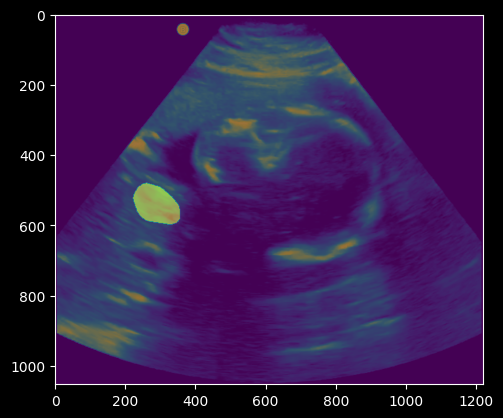

In [27]:
plt.figure()
plt.imshow(ob[0])
plt.imshow(gt_video[0], alpha=0.5)

449
638


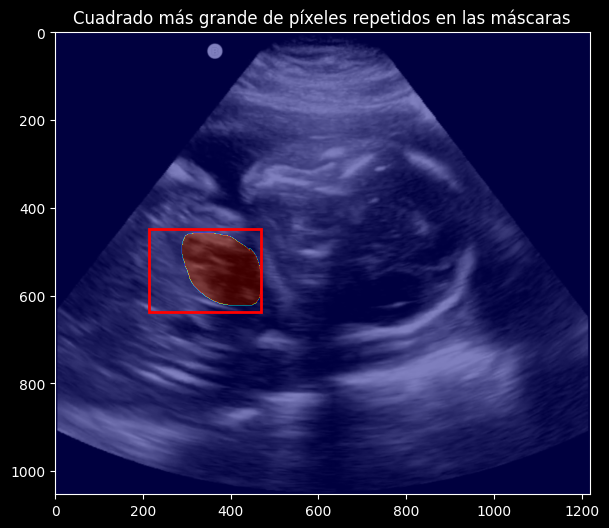

In [28]:
import matplotlib.patches as patches
# Calcular el centro de la máscara en cada frame donde haya información
centers = []
rows_min = []
rows_max = []
cols_min = []
cols_max = []
max_value = 0
id_max = 0
for i in range(ob.shape[0]):
    mask_i = ob[i]
    # Solo considerar frames con segmentación (máscara no vacía)
    if np.sum(mask_i) > 0:
        # Obtener las posiciones de las columnas donde la máscara es positiva
        row, cols = np.where(mask_i > 0)
        centers.append(np.mean(cols))
        rows_min.append(row.min())
        rows_max.append(row.max())
        cols_min.append(cols.min())
        cols_max.append(cols.max())
        if cols.max() > max_value:
            max_value = cols.max()
            id_max = i

if len(centers) > 0:
    # Calcular el centro promedio a lo largo de todos los frames
    col_center = int(np.mean(centers))
else:
    # En caso de que ninguna máscara tenga segmentación, usar la columna central del frame
    col_center = gt_video.shape[2] // 2

# Definir la ventana de columnas a extraer (por ejemplo, 10 columnas centradas en col_center)
window_size = 10
half_window = window_size // 2
col_start = max(0, col_center - half_window)
col_end = min(gt_video.shape[2], col_center + half_window)
col_start=min(cols_min)
col_end=max(cols_max)
row_start=min(rows_min)
row_end=max(rows_max)
# Visualizar un frame de ejemplo con la región extraída marcada
sample_frame_index = id_max
sample_frame = gt_video[sample_frame_index, :, :]
print(min(rows_min))
print(max(rows_max))

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(sample_frame, cmap='gray')
ax.imshow(ob[sample_frame_index], alpha=0.5, cmap='jet')

# Dibujar el cuadrado encontrado
rect = patches.Rectangle((col_start, row_start), col_end - col_start, row_end - row_start, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.set_title('Cuadrado más grande de píxeles repetidos en las máscaras')
plt.show()


Se generaron 12 regiones aleatorias después de 18 intentos.


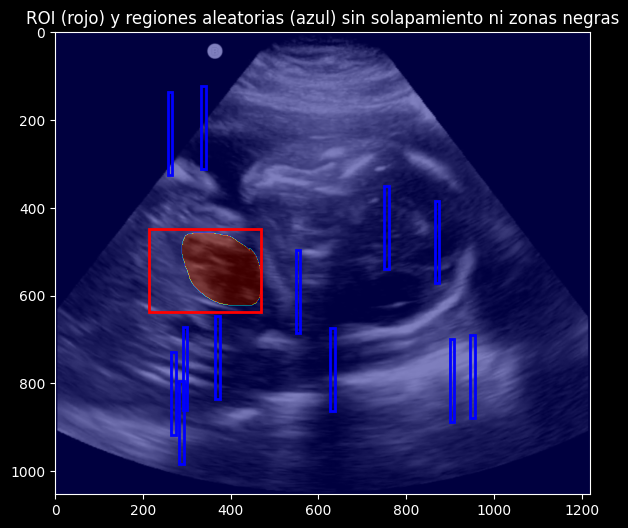

In [29]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Suponiendo que ya tienes:
# - row_start, row_end, col_start, col_end (definen la ROI principal)
# - sample_frame (frame 2D donde deseas ubicar las cajas)
# - ob y sample_frame_index (para superponer la máscara en la visualización)

height, width = sample_frame.shape

# Dimensiones de las cajas aleatorias:
roi_height = row_end - row_start   # misma altura que la ROI
roi_width = 10                 # ancho fijo de 10 columnas

# Caja principal (ROI) en formato (y0, x0, y1, x1)
roi_box = (row_start, col_start, row_end, col_end)

def intersect(boxA, boxB):
    """
    Devuelve True si boxA y boxB se solapan.
    Cada box se define como (y0, x0, y1, x1).
    """
    return not (
        boxA[1] >= boxB[3] or  # A está a la derecha de B
        boxA[3] <= boxB[1] or  # A está a la izquierda de B
        boxA[0] >= boxB[2] or  # A está debajo de B
        boxA[2] <= boxB[0]     # A está encima de B
    )

def is_black_region(img, r0, c0, r1, c1, threshold=10):
    """
    Retorna True si la suma de intensidades en la subimagen
    (r0:r1, c0:c1) es menor que 'threshold'.
    """
    sub = img[r0:r1, c0:c1]
    return np.sum(sub) < threshold

n_random = 12
random_boxes = []
attempts = 0
max_attempts = 1000

while len(random_boxes) < n_random and attempts < max_attempts:
    attempts += 1
    # Elegir aleatoriamente la esquina superior izquierda
    rand_row0 = random.randint(0, height - roi_height)
    rand_col0 = random.randint(0, width - roi_width)
    rand_row1 = rand_row0 + roi_height
    rand_col1 = rand_col0 + roi_width
    new_box = (rand_row0, rand_col0, rand_row1, rand_col1)

    # Verificar que no se solape con la ROI
    if not intersect(roi_box, new_box):
        # Verificar que no sea "completamente negra"
        if not is_black_region(sample_frame, rand_row0, rand_col0, rand_row1, rand_col1, threshold=10):
            random_boxes.append(new_box)

print(f"Se generaron {len(random_boxes)} regiones aleatorias después de {attempts} intentos.")

# Visualizar la ROI (en rojo) y las regiones aleatorias (en azul)
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(sample_frame, cmap='gray')
ax.imshow(ob[sample_frame_index], alpha=0.5, cmap='jet')

# Dibujar la ROI principal
roi_rect = patches.Rectangle(
    (col_start, row_start),
    col_end - col_start,
    row_end - row_start,
    edgecolor='r',
    facecolor='none',
    linewidth=2
)
ax.add_patch(roi_rect)

# Dibujar cada caja aleatoria en azul
for (r0, c0, r1, c1) in random_boxes:
    rect = patches.Rectangle(
        (c0, r0),
        c1 - c0,
        r1 - r0,
        edgecolor='b',
        facecolor='none',
        linewidth=2
    )
    ax.add_patch(rect)

plt.title("ROI (rojo) y regiones aleatorias (azul) sin solapamiento ni zonas negras")
plt.show()


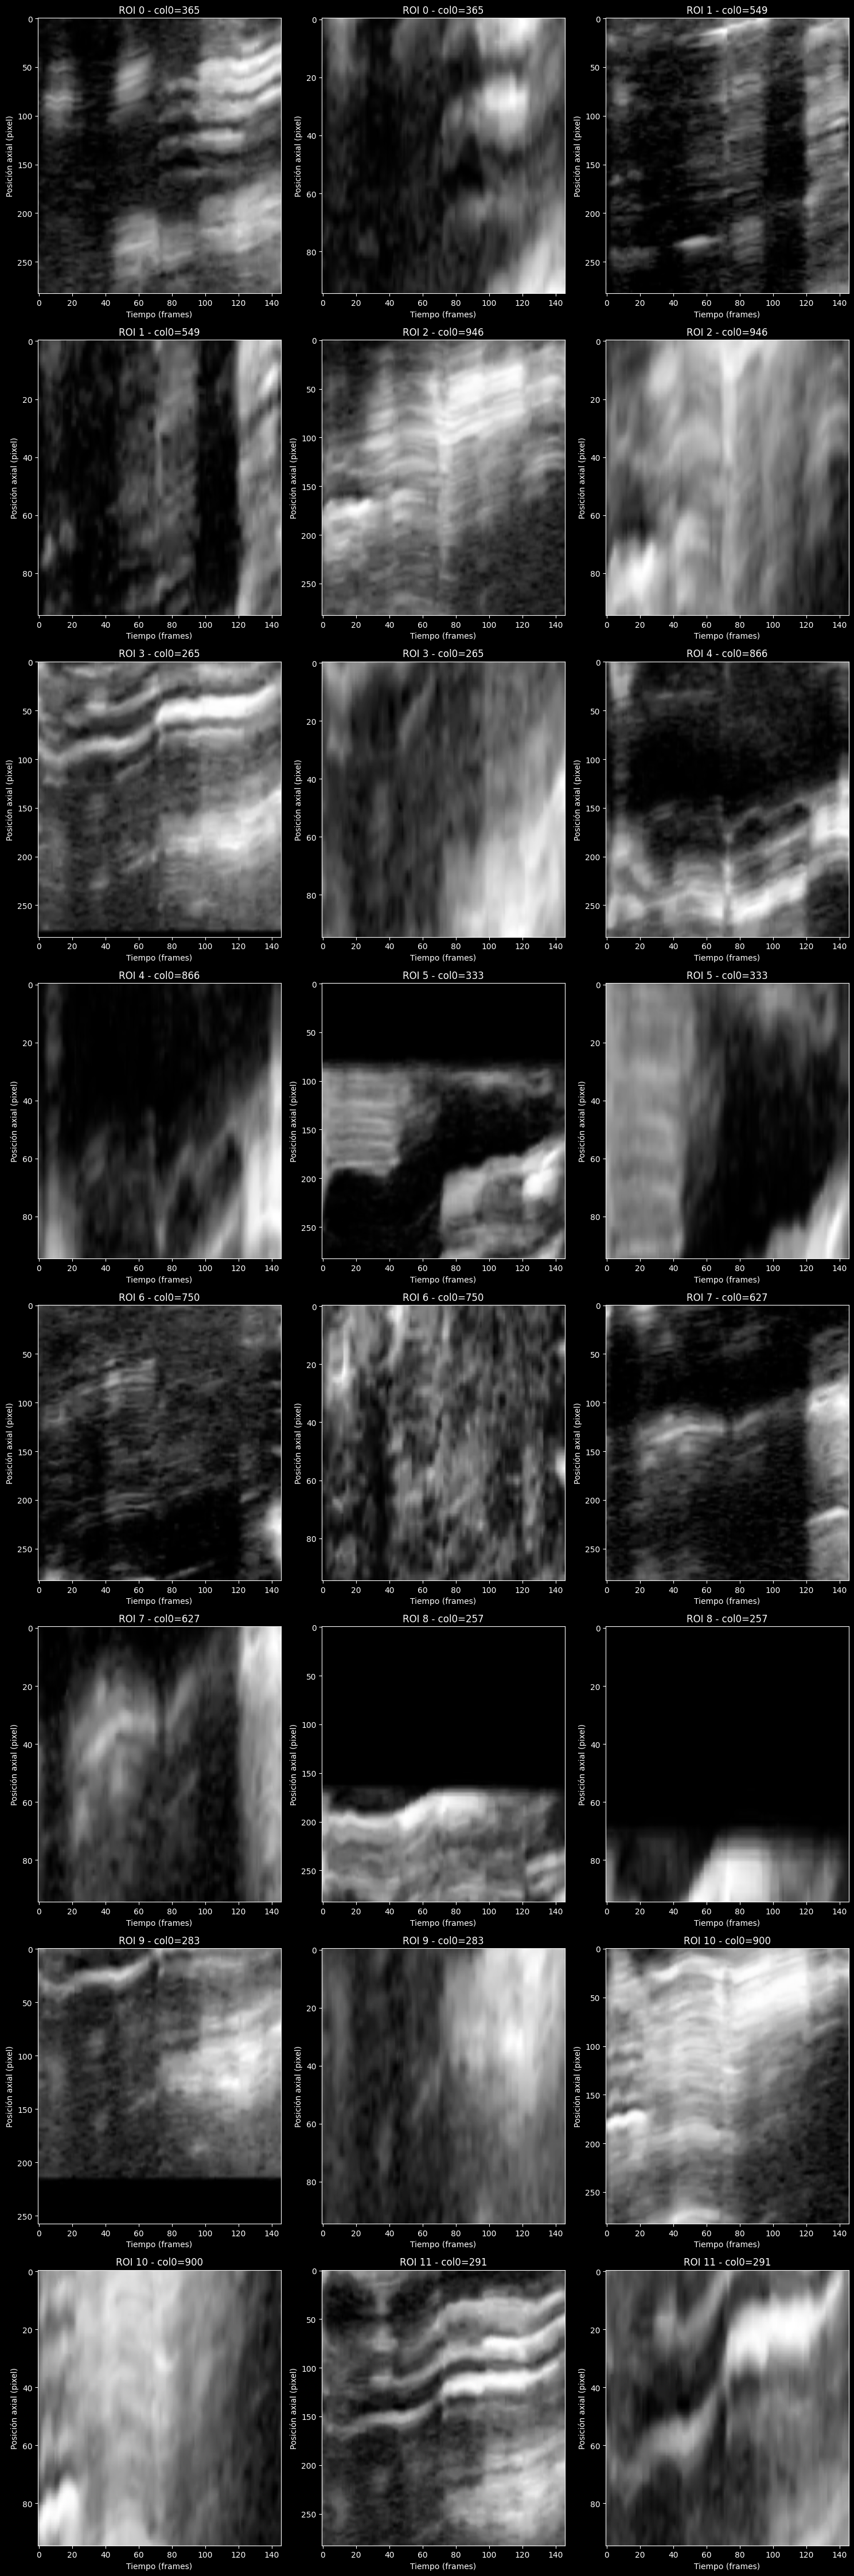

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que random_boxes es una lista con 12 cajas generadas previamente.
# Cada caja tiene el formato: (row0, col0, row1, col1)
# Por ejemplo:
# random_boxes = [(r0, c0, r1, c1), (r0, c0, r1, c1), ..., (r0, c0, r1, c1)]

# Extraer los ROI_videos de cada random_box:
roi_videos = []
for box in random_boxes:
    r0, c0, r1, c1 = box
    # Extraemos la ROI del video para cada caja.
    #roi_video = gt_video[:, r0:r1, c0:c1]
    roi_video = gt_video[:, r0:r1+ (r1-r0)//2, c0:c1]
    roi_videos.append(roi_video)
    roi_video=gt_video[:, r0+ (r1-r0)//2:r1, c0:c1]
    roi_videos.append(roi_video)


# Ahora, para cada ROI, calculamos la imagen M‑mode.
# Esto se hace promediando a lo largo de las columnas (axis=2) para obtener un perfil axial
count=0
plt.figure(figsize=(15, 45))
for i, roi_video in enumerate(roi_videos):
    # Calcular el M‑mode: cada fila es el perfil axial en cada frame
    m_mode_image = np.mean(roi_video, axis=2)
    
    # Graficar en un subplot (disponemos de 12, así que podemos usar, por ejemplo, 4 filas x 3 columnas)
    plt.subplot(8, 3, i + 1)
    plt.imshow(m_mode_image.T, aspect='auto', cmap='gray')
    # Mostramos en el título la posición de la columna inicial de la caja (o cualquier dato relevante)
    #plt.title(f'ROI {i} - col0={random_boxes[i][1]}')
   
    plt.title(f'ROI {count} - col0={random_boxes[count][1]}')
    if i%2!=0:
            count+=1
    plt.xlabel('Tiempo (frames)')
    plt.ylabel('Posición axial (pixel)')

plt.tight_layout()
plt.show()


ROI 0 => BPM: 143.84
ROI 1 => BPM: 123.29
ROI 2 => BPM: 102.74
ROI 3 => BPM: 102.74
ROI 4 => BPM: 113.01
ROI 5 => BPM: 113.01
ROI 6 => BPM: 123.29
ROI 7 => BPM: 123.29
ROI 8 => BPM: 123.29
ROI 9 => BPM: 113.01
ROI 10 => BPM: 143.84
ROI 11 => BPM: 143.84
ROI 12 => BPM: 92.47
ROI 13 => BPM: 113.01
ROI 14 => BPM: 102.74
ROI 15 => BPM: 102.74
ROI 16 => BPM: 113.01
ROI 17 => BPM: 113.01
ROI 18 => BPM: 113.01
ROI 19 => BPM: 102.74
ROI 20 => BPM: 113.01
ROI 21 => BPM: 113.01
ROI 22 => BPM: 113.01
ROI 23 => BPM: 102.74

BPM Promedio: 114.88
BPM Mediana: 113.01
Desviación Estándar BPM: 11.44


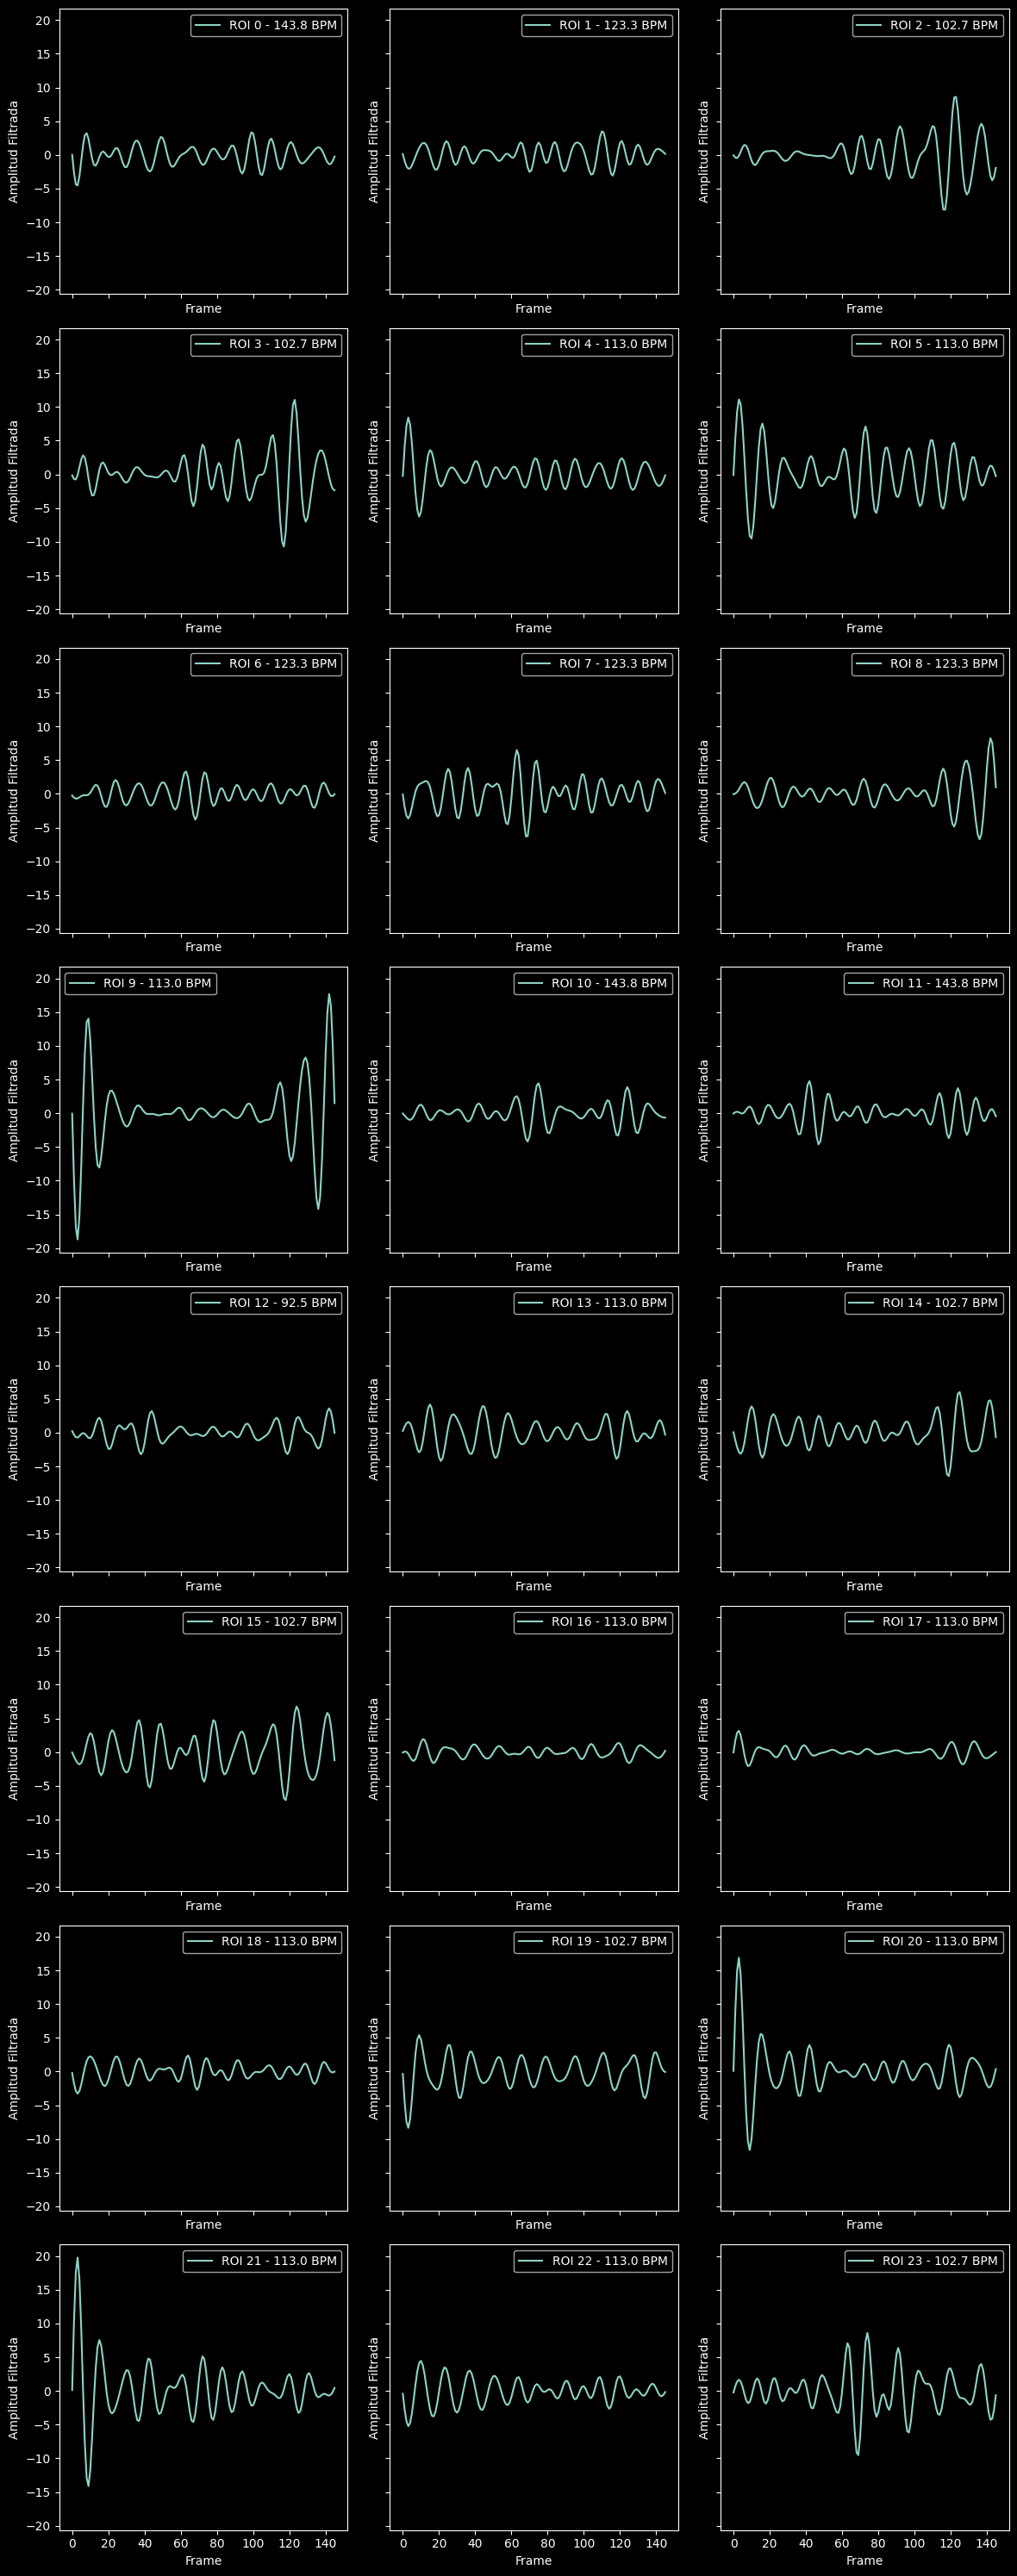

[np.float64(113.01369863013699), np.float64(123.2876712328767), np.float64(102.73972602739725), np.float64(143.83561643835614)]


In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que ya tienes definidas:
# - roi_videos: lista de videos ROI (cada uno con forma (n_frames, altura, 10 columnas))
# - m_mode_image_clas: M-mode obtenido de una ROI "discriminativa" (por ejemplo, en el centro)
# - La función analizar_m_mode definida previamente, que devuelve (bpm, freq_dom, signal_filtrada)

# Obtener las imágenes M-mode de cada ROI promediando la dimensión de columnas
m_mode_images = [np.mean(roi_video, axis=2) for roi_video in roi_videos]


# Por ejemplo, filtramos entre 0.8 y 2.5 Hz (48 - 180 BPM)
#lowcut = 1.5
#highcut = 3
lowcut=1.5
highcut=3

# Analizar cada M-mode para extraer BPM
bpm_values = []
for i, m_mode_img in enumerate(m_mode_images):
    bpm, freq_dom, signal_filtrada = analizar_m_mode(m_mode_img)
    bpm_values.append(bpm)
    print(f"ROI {i} => BPM: {bpm:.2f}")

#sort bpm_values
bpm_values.sort()
#eliminar el primer y el último valor
bpm_values_discriminate=bpm_values[1:-1]
# Calcular estadísticas: promedio, mediana y desviación estándar de BPM
bpm_mean   = np.mean(bpm_values_discriminate)
bpm_median = np.median(bpm_values_discriminate)
bpm_std    = np.std(bpm_values_discriminate)
bpm_values_discriminate=list(set(bpm_values_discriminate))

print(f"\nBPM Promedio: {bpm_mean:.2f}")
print(f"BPM Mediana: {bpm_median:.2f}")
print(f"Desviación Estándar BPM: {bpm_std:.2f}")

# Graficar la señal filtrada de cada ROI en un grid (por ejemplo, 4 filas x 3 columnas)
fig, axs = plt.subplots(8, 3, figsize=(12, 30), sharex=True, sharey=True)
axs = axs.ravel()

for i, m_mode_img in enumerate(m_mode_images):
    bpm, freq_dom, signal_filtrada = analizar_m_mode(m_mode_img)
    axs[i].plot(signal_filtrada, label=f'ROI {i} - {bpm:.1f} BPM')
    axs[i].legend()
    axs[i].set_xlabel('Frame')
    axs[i].set_ylabel('Amplitud Filtrada')

plt.tight_layout()
plt.show()

print(bpm_values_discriminate)

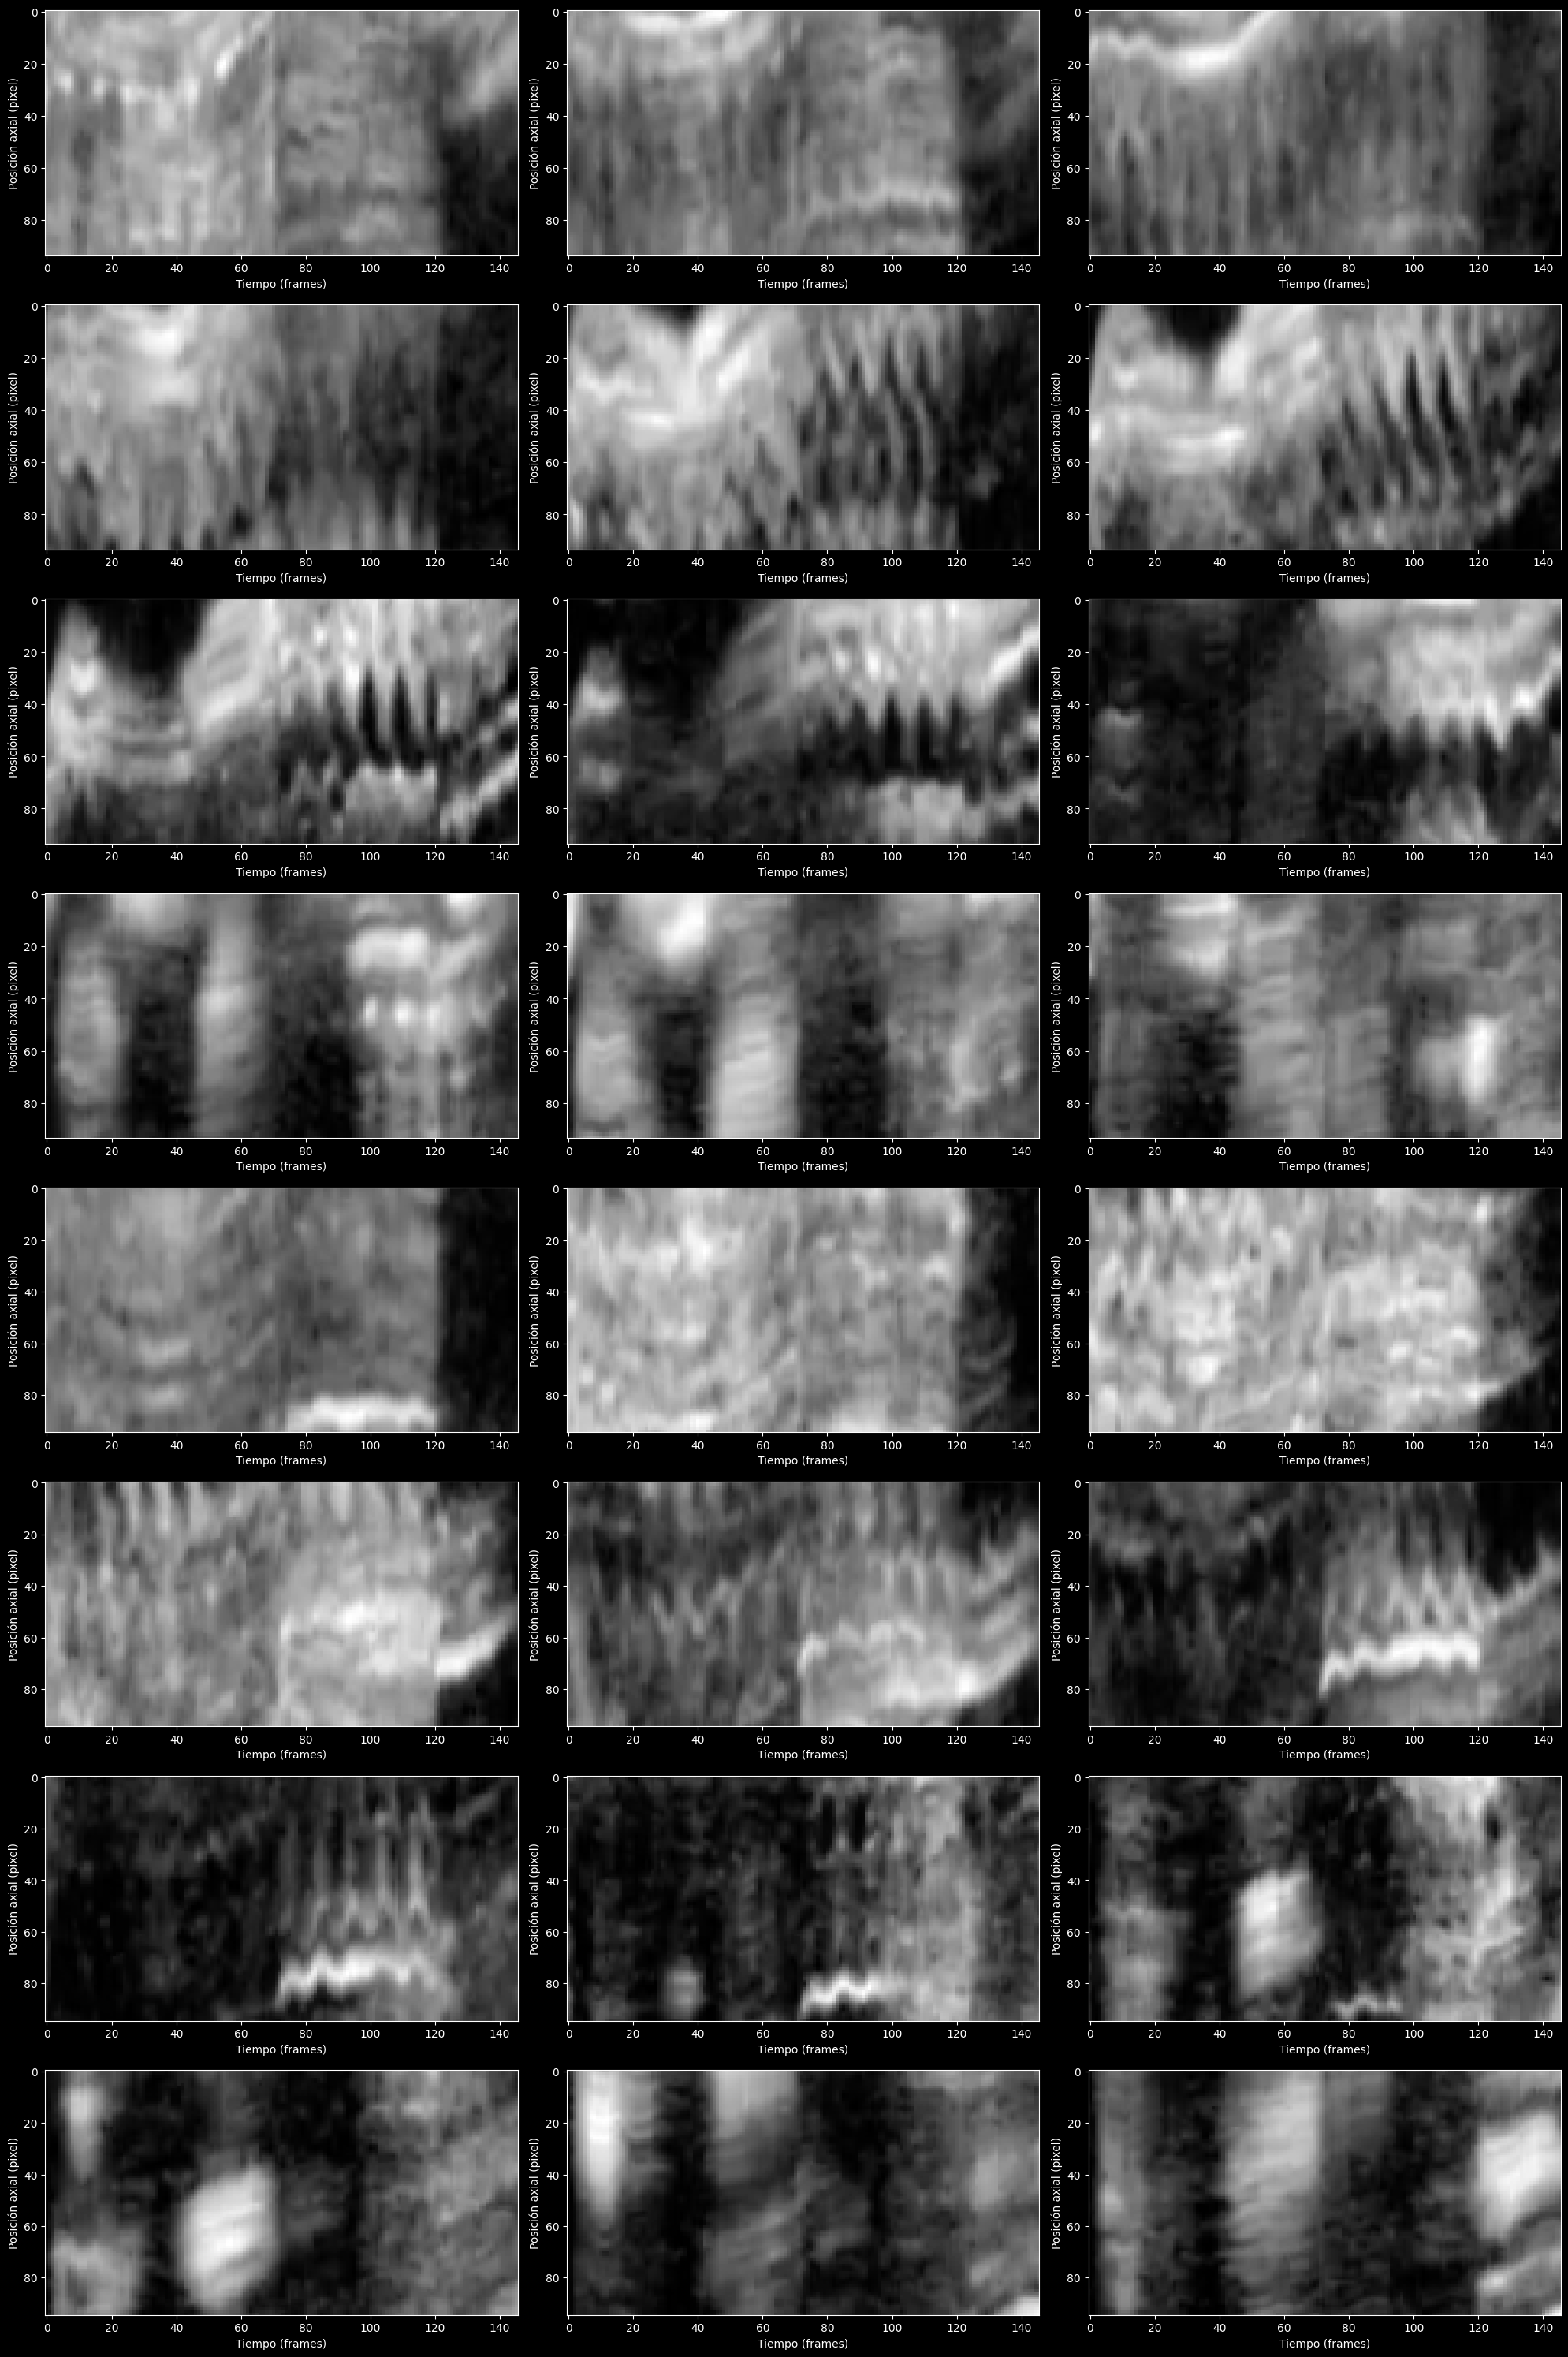

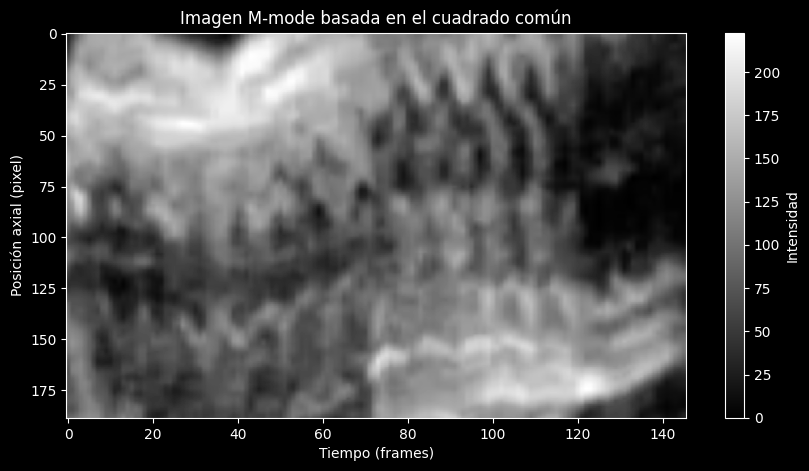

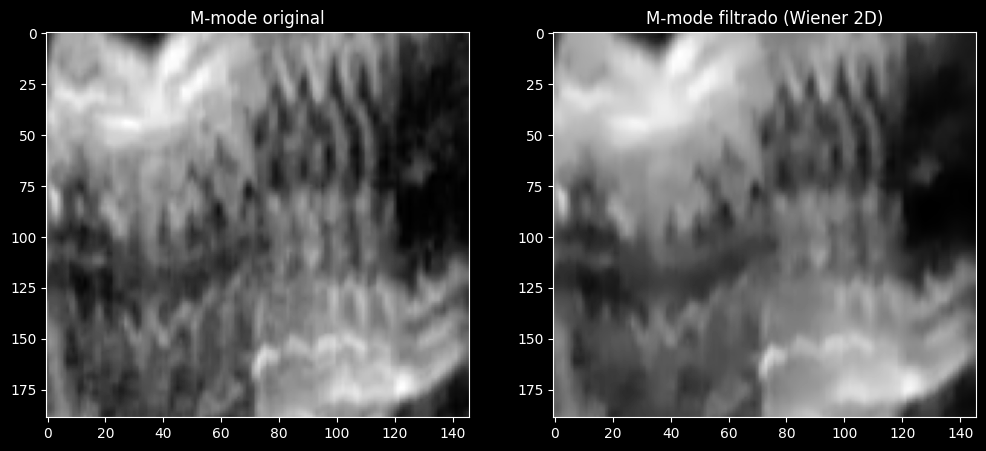

(146, 189)


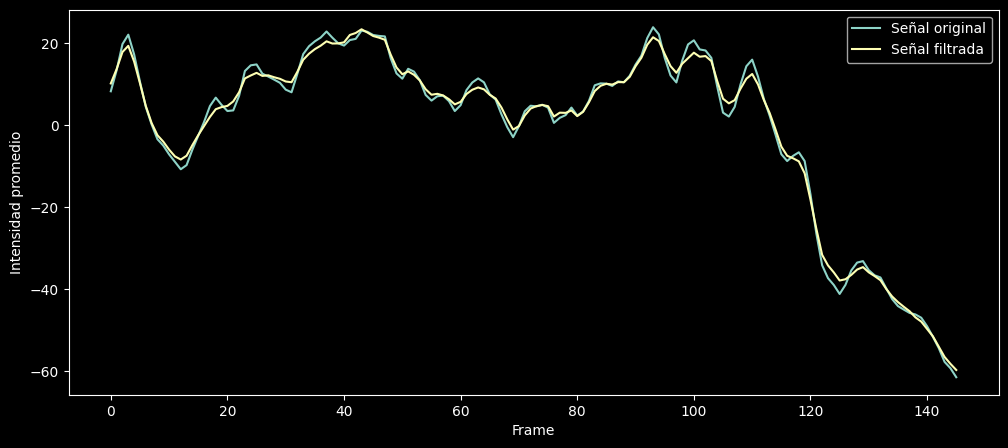

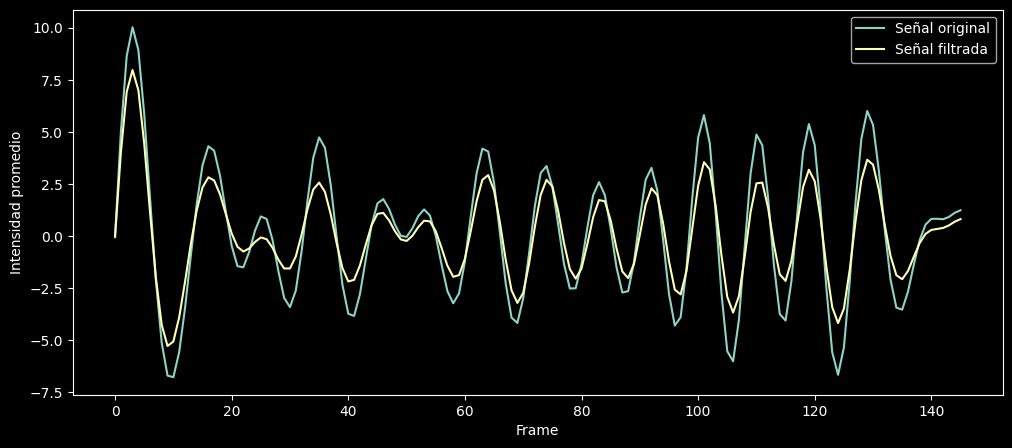

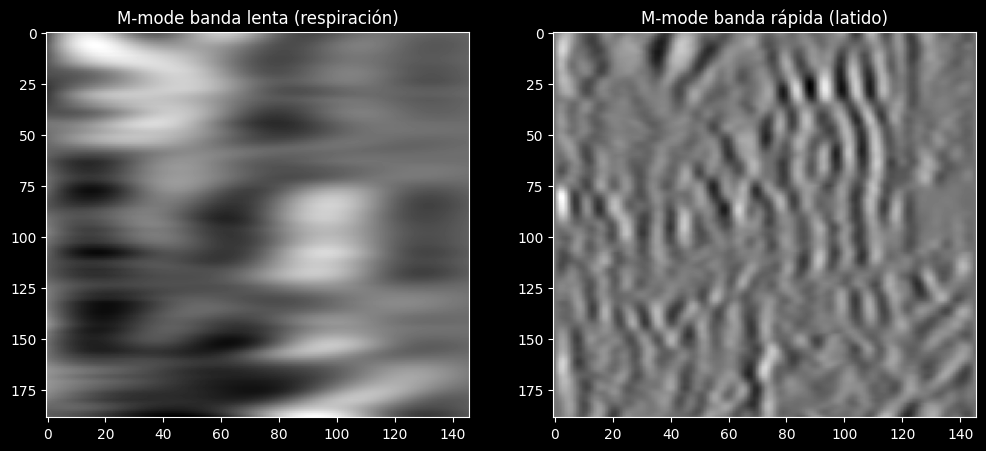

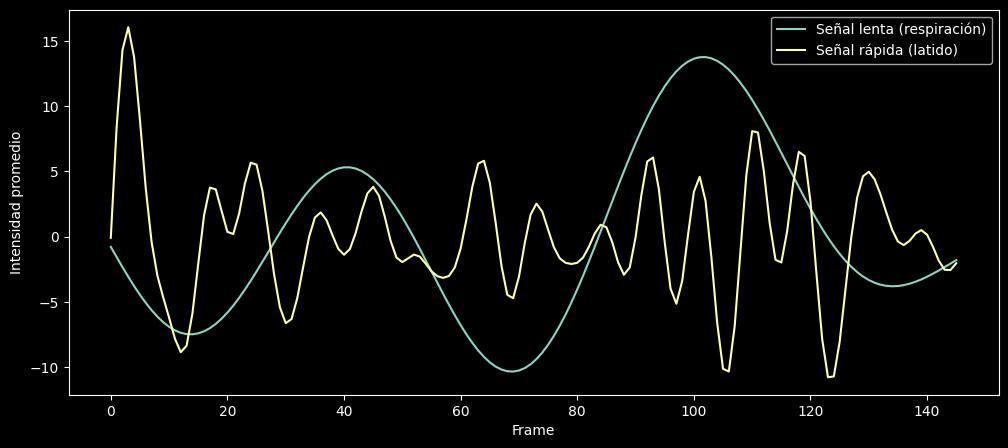

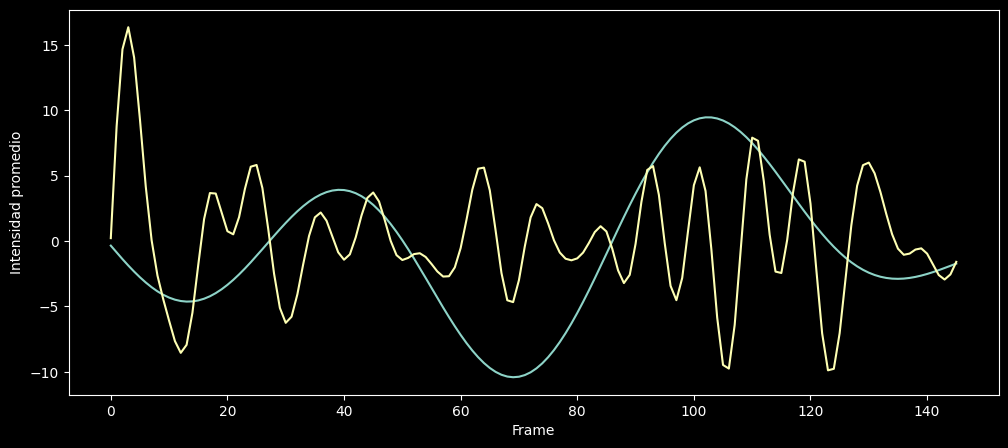

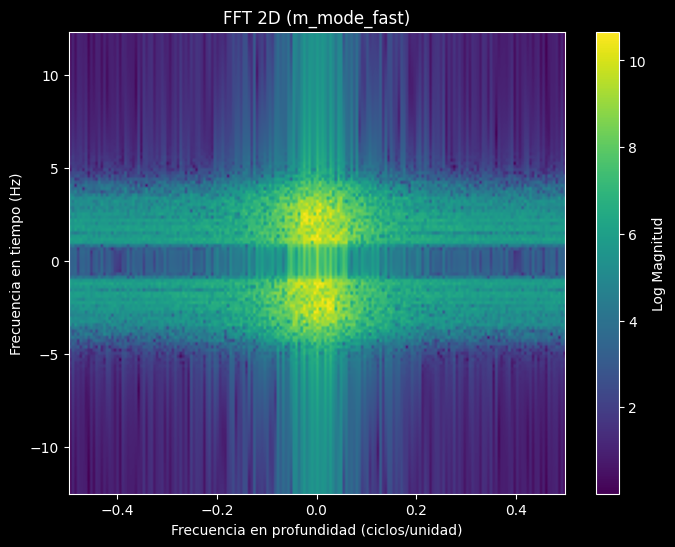

Frecuencia dominante: 1.20 Hz => 71.9 BPM


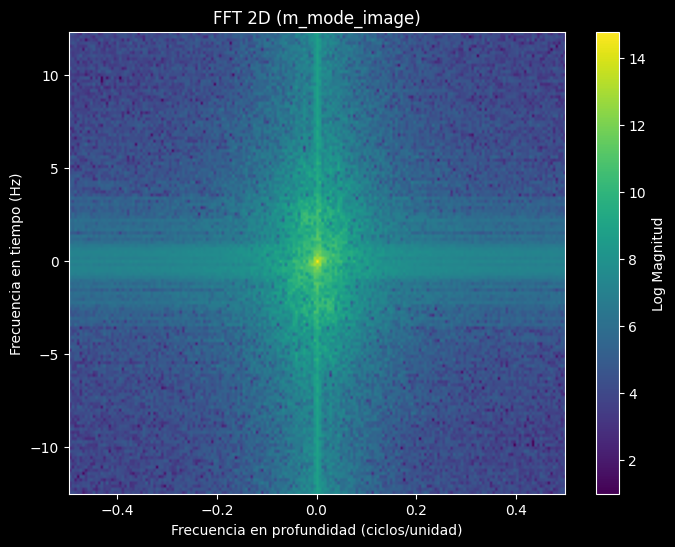

Frecuencia dominante: 1.03 Hz => 61.6 BPM


In [32]:
#extract 12 spaced col_values from the range col_start to col_end
col_values = np.linspace(col_start, col_end, num=12, dtype=int)

#create roi_videos with 10 columns each starting from col_values and height from row_start to the range divided by 2
roi_videos = [gt_video[:, row_start:row_start + (row_end-row_start)//2, col:col + 10] for col in col_values]
#append the other half of the roi_videos
roi_videos += [gt_video[:, row_start + (row_end-row_start)//2:row_end, col:col + 10] for col in col_values]

#roi_videos = [gt_video[:, row_start:row_end, col:col + window_size] for col in col_values]

#plot the 3 roi_videos in m-mode format
plt.figure(figsize=(20, 30))
for i, roi_video in enumerate(roi_videos):
    m_mode_image = np.mean(roi_video, axis=2)
    plt.subplot(8, 3, i + 1)
    plt.imshow(m_mode_image.T, aspect='auto', cmap='gray')
    #plt.title(f'ROI en col={col_values[i]}')
    plt.xlabel('Tiempo (frames)')
    plt.ylabel('Posición axial (pixel)')

plt.tight_layout()
plt.show()

roi_video = gt_video[:, row_start:row_end, 307:320]


# Generar la imagen M‑mode a partir de la ROI:
# Se promedia a lo largo de las columnas para obtener, en cada frame, un perfil axial.
m_mode_image = np.mean(roi_video, axis=2)  # Resultado con forma (n_frames, max_size)
#m_mode_image=m_mode_image[70:-30,0:100]

# Visualizar la imagen M‑mode
plt.figure(figsize=(10, 5))
plt.imshow(m_mode_image.T, aspect='auto', cmap='gray')
plt.title('Imagen M‑mode basada en el cuadrado común')
plt.xlabel('Tiempo (frames)')
plt.ylabel('Posición axial (pixel)')
plt.colorbar(label='Intensidad')
plt.show()

import numpy as np
from scipy.ndimage import uniform_filter

def adaptive_noise_removal_lim(m_mode_image, window_size=10):
    """
    Aplica un filtro adaptativo 2D basado en la ecuación de Lim (1990).
    A cada píxel (i,j) se le aplica:
        B(i,j) = mu + (sigma^2 / (sigma^2 + v^2)) * (A(i,j) - mu)
    donde mu y sigma^2 son la media y varianza locales en una ventana,
    y v^2 es la varianza del ruido estimada.
    """
    # 1) Convertir a float para evitar saturaciones
    A = m_mode_image.astype(np.float32)

    # 2) Calcular la media local con uniform_filter (ventana NxN)
    size = (window_size, window_size)
    local_mean = uniform_filter(A, size=size)

    # 3) Calcular la varianza local = E(A^2) - (E(A))^2
    local_mean_sq = uniform_filter(A*A, size=size)
    local_var = local_mean_sq - local_mean*local_mean

    # 4) Estimar la varianza de ruido (v^2)
    #    Puede ser la mediana de local_var, o un valor fijo de antemano
    noise_var = np.median(local_var)

    # Evitar ceros que provoquen inestabilidad numérica
    sigma2 = np.where(local_var < 1e-8, 1e-8, local_var)

    # 5) Aplicar la ecuación de Lim (filtro adaptativo)
    B = local_mean + (sigma2 / (sigma2 + noise_var)) * (A - local_mean)

    return B

# Ejemplo de uso con una imagen M-mode 2D (tiempo x profundidad):
filtered_m_mode = adaptive_noise_removal_lim(m_mode_image, window_size=10)


# Visualizar comparación
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.title("M-mode original")
plt.imshow(m_mode_image.T, aspect='auto', cmap='gray')

plt.subplot(1,2,2)
plt.title("M-mode filtrado (Wiener 2D)")
plt.imshow(filtered_m_mode.T, aspect='auto', cmap='gray')
plt.show()


print(filtered_m_mode.shape)

signal_new=np.mean(m_mode_image, axis=1)
signal_new_filtered=np.mean(filtered_m_mode, axis=1)

signal_new -= np.mean(signal_new)
signal_f_new = bandpass_filter(signal_new, lowcut, highcut, fs)

signal_new_filtered -= np.mean(signal_new_filtered)
signal_f_new_filtered = bandpass_filter(signal_new_filtered, lowcut, highcut, fs)


plt.figure(figsize=(12, 5))
plt.plot(signal_new, label='Señal original')
plt.plot(signal_new_filtered, label='Señal filtrada')
plt.xlabel('Frame')
plt.ylabel('Intensidad promedio')
plt.legend()

plt.figure(figsize=(12, 5))
plt.plot(signal_f_new, label='Señal original')
plt.plot(signal_f_new_filtered, label='Señal filtrada')
plt.xlabel('Frame')
plt.ylabel('Intensidad promedio')
plt.legend()


import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def filter_mmode_by_rows(m_mode, fs, lowcut, highcut):
    """
    Aplica un filtro pasa banda a cada fila (eje tiempo) de la imagen M-mode.
    m_mode: np.array de forma (n_frames, n_depth)
    fs: frecuencia de muestreo (frames por segundo)
    lowcut, highcut: límites de la banda en Hz
    """
    filtered = np.zeros_like(m_mode)
    n_frames, n_depth = m_mode.shape
    
    for d in range(n_depth):
        row_signal = m_mode[:, d]
        # Opcional: quitar componente DC
        row_signal = row_signal - np.mean(row_signal)
        filtered_row = bandpass_filter(row_signal, lowcut, highcut, fs)
        filtered[:, d] = filtered_row
    return filtered

# Supongamos que m_mode_image tiene forma (tiempo, profundidad).
# FS = 25 fps, banda lenta ~ (0.1-0.5 Hz), banda rápida ~ (1-4 Hz).
fs = 25
m_mode_slow = filter_mmode_by_rows(m_mode_image, fs, 0.1, 0.5)
m_mode_fast = filter_mmode_by_rows(m_mode_image, fs, 1.0, 4.0)

# Visualizar ambos
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(m_mode_slow.T, aspect='auto', cmap='gray')
plt.title("M-mode banda lenta (respiración)")

plt.subplot(1,2,2)
plt.imshow(m_mode_fast.T, aspect='auto', cmap='gray')
plt.title("M-mode banda rápida (latido)")
plt.show()


#signal of m_mode_slow and m_mode_fast
signal_slow = np.mean(m_mode_slow, axis=1)
signal_fast = np.mean(m_mode_fast, axis=1)

#eliminar dc component
signal_slow -= np.mean(signal_slow)
signal_fast -= np.mean(signal_fast)

#bandpass filter
signal_f_slow = bandpass_filter(signal_slow, 0.1, 0.5, fs)
signal_f_fast = bandpass_filter(signal_fast, 1.0, 4.0, fs)

plt.figure(figsize=(12, 5))
plt.plot(signal_slow, label='Señal lenta (respiración)')
plt.plot(signal_fast, label='Señal rápida (latido)')
plt.xlabel('Frame')
plt.ylabel('Intensidad promedio')
plt.legend()

plt.figure(figsize=(12, 5))
plt.plot(signal_f_slow, label='Señal lenta (respiración)')
plt.plot(signal_f_fast, label='Señal rápida (latido)')
plt.xlabel('Frame')
plt.ylabel('Intensidad promedio')

import numpy as np
import matplotlib.pyplot as plt

# m_mode_fast: np.array con shape (n_frames, n_depth)

# 1) Calcular la FFT 2D
F = np.fft.fft2(m_mode_fast)        # FFT 2D
F_shifted = np.fft.fftshift(F)      # Centrar el cero de frecuencia

# 2) Calcular la magnitud y usar log para mejor visualización
magnitude_spectrum = np.log1p(np.abs(F_shifted))

# 3) Crear ejes de frecuencia (opcional, para etiquetar)
#    - freq_t: frecuencias en el eje tiempo
#    - freq_d: frecuencias en el eje profundidad
n_frames, n_depth = m_mode_fast.shape
fs_t = 25.0  # Por ejemplo, 25 fps (ajusta si es distinto)
d_depth = 1.0  # Asume 1 px = 1 unidad de profundidad (ajusta según tu escala real)

freq_t = np.fft.fftfreq(n_frames, d=1/fs_t)  # frecuencias asociadas al eje tiempo
freq_d = np.fft.fftfreq(n_depth, d=d_depth)  # frecuencias asociadas al eje profundidad

# Desplazar (fftshift) los ejes de frecuencia para alinear con F_shifted
freq_t_shifted = np.fft.fftshift(freq_t)
freq_d_shifted = np.fft.fftshift(freq_d)

# 4) Visualizar el espectro 2D
plt.figure(figsize=(8,6))
# extent define el rango de los ejes en la imagen: (x_min, x_max, y_min, y_max)
plt.imshow(magnitude_spectrum, 
           extent=[freq_d_shifted[0], freq_d_shifted[-1], 
                   freq_t_shifted[0], freq_t_shifted[-1]],
           aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Log Magnitud')
plt.title("FFT 2D (m_mode_fast)")
plt.xlabel("Frecuencia en profundidad (ciclos/unidad)")
plt.ylabel("Frecuencia en tiempo (Hz)")
plt.show()



import numpy as np

# magnitude_spectrum.shape -> (n_frames, n_depth) después de fftshift
# freq_t_shifted y freq_d_shifted son los ejes de frecuencia en tiempo y en profundidad.

# 1) Para obtener un espectro 1D en la dimensión temporal,
#    sumamos la magnitud a lo largo del eje de frecuencia espacial (depth).
spectrum_1d = np.sum(magnitude_spectrum, axis=1)  # Suma columnas

# 2) Aislar las frecuencias positivas en el eje de tiempo (freq_t_shifted)
#    Buscamos freq_t_shifted >= 0
mask_positive = (freq_t_shifted >= 0)
freq_t_pos = freq_t_shifted[mask_positive]
spectrum_1d_pos = spectrum_1d[mask_positive]

# 3) Localizar el pico en la banda cardíaca (1-3 Hz, p.ej.)
band_mask = (freq_t_pos >= 1.0) & (freq_t_pos <= 3.0)
freq_band = freq_t_pos[band_mask]
spectrum_band = spectrum_1d_pos[band_mask]

# 4) Hallar el índice del pico
if len(spectrum_band) > 0:
    idx_peak = np.argmax(spectrum_band)
    freq_peak = freq_band[idx_peak]
    bpm = freq_peak * 60
    print(f"Frecuencia dominante: {freq_peak:.2f} Hz => {bpm:.1f} BPM")
else:
    print("No se encontró un pico en la banda esperada.")






# m_mode_fast: np.array con shape (n_frames, n_depth)

# 1) Calcular la FFT 2D
F = np.fft.fft2(m_mode_image)        # FFT 2D
F_shifted = np.fft.fftshift(F)      # Centrar el cero de frecuencia

# 2) Calcular la magnitud y usar log para mejor visualización
magnitude_spectrum = np.log1p(np.abs(F_shifted))

# 3) Crear ejes de frecuencia (opcional, para etiquetar)
#    - freq_t: frecuencias en el eje tiempo
#    - freq_d: frecuencias en el eje profundidad
n_frames, n_depth = m_mode_fast.shape
fs_t = 25.0  # Por ejemplo, 25 fps (ajusta si es distinto)
d_depth = 1.0  # Asume 1 px = 1 unidad de profundidad (ajusta según tu escala real)

freq_t = np.fft.fftfreq(n_frames, d=1/fs_t)  # frecuencias asociadas al eje tiempo
freq_d = np.fft.fftfreq(n_depth, d=d_depth)  # frecuencias asociadas al eje profundidad

# Desplazar (fftshift) los ejes de frecuencia para alinear con F_shifted
freq_t_shifted = np.fft.fftshift(freq_t)
freq_d_shifted = np.fft.fftshift(freq_d)

# 4) Visualizar el espectro 2D
plt.figure(figsize=(8,6))
# extent define el rango de los ejes en la imagen: (x_min, x_max, y_min, y_max)
plt.imshow(magnitude_spectrum, 
           extent=[freq_d_shifted[0], freq_d_shifted[-1], 
                   freq_t_shifted[0], freq_t_shifted[-1]],
           aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Log Magnitud')
plt.title("FFT 2D (m_mode_image)")
plt.xlabel("Frecuencia en profundidad (ciclos/unidad)")
plt.ylabel("Frecuencia en tiempo (Hz)")
plt.show()

import numpy as np

# magnitude_spectrum.shape -> (n_frames, n_depth) después de fftshift
# freq_t_shifted y freq_d_shifted son los ejes de frecuencia en tiempo y en profundidad.

# 1) Para obtener un espectro 1D en la dimensión temporal,
#    sumamos la magnitud a lo largo del eje de frecuencia espacial (depth).
spectrum_1d = np.sum(magnitude_spectrum, axis=1)  # Suma columnas

# 2) Aislar las frecuencias positivas en el eje de tiempo (freq_t_shifted)
#    Buscamos freq_t_shifted >= 0
mask_positive = (freq_t_shifted >= 0)
freq_t_pos = freq_t_shifted[mask_positive]
spectrum_1d_pos = spectrum_1d[mask_positive]

# 3) Localizar el pico en la banda cardíaca (1-3 Hz, p.ej.)
band_mask = (freq_t_pos >= 1.0) & (freq_t_pos <= 3.0)
freq_band = freq_t_pos[band_mask]
spectrum_band = spectrum_1d_pos[band_mask]

# 4) Hallar el índice del pico
if len(spectrum_band) > 0:
    idx_peak = np.argmax(spectrum_band)
    freq_peak = freq_band[idx_peak]
    bpm = freq_peak * 60
    print(f"Frecuencia dominante: {freq_peak:.2f} Hz => {bpm:.1f} BPM")
else:
    print("No se encontró un pico en la banda esperada.")



ROI 0 => BPM: 143.84
ROI 1 => BPM: 174.66
ROI 2 => BPM: 154.11
ROI 3 => BPM: 143.84
ROI 4 => BPM: 154.11
ROI 5 => BPM: 164.38
ROI 6 => BPM: 133.56
ROI 7 => BPM: 143.84
ROI 8 => BPM: 143.84
ROI 9 => BPM: 133.56
ROI 10 => BPM: 102.74
ROI 11 => BPM: 102.74
ROI 12 => BPM: 154.11
ROI 13 => BPM: 113.01
ROI 14 => BPM: 92.47
ROI 15 => BPM: 143.84
ROI 16 => BPM: 164.38
ROI 17 => BPM: 154.11
ROI 18 => BPM: 143.84
ROI 19 => BPM: 102.74
ROI 20 => BPM: 133.56
ROI 21 => BPM: 143.84
ROI 22 => BPM: 113.01
ROI 23 => BPM: 92.47

BPM Promedio: 135.27
BPM Mediana: 143.84
Desviación Estándar BPM: 23.29


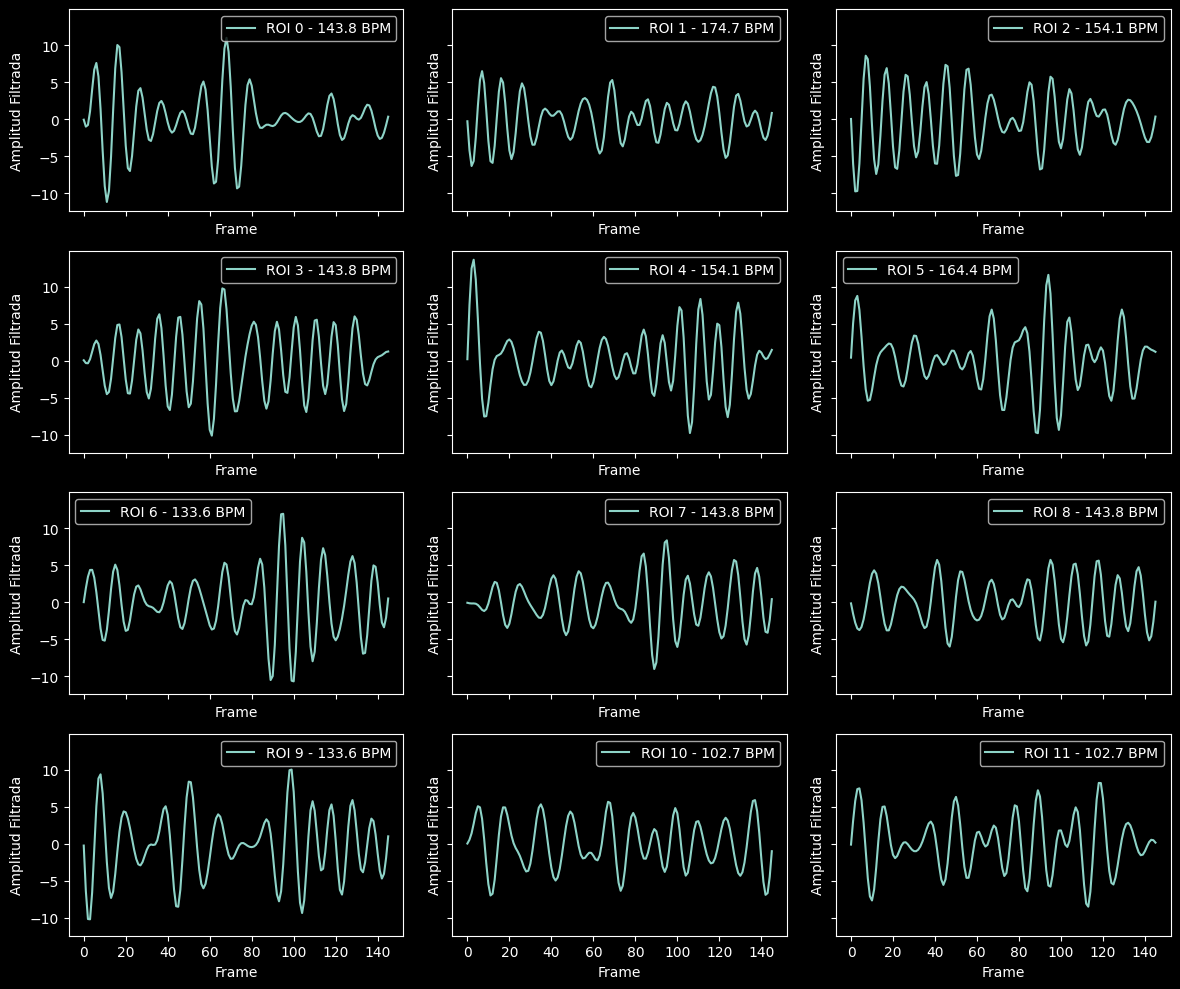

[np.float64(164.3835616438356), np.float64(133.56164383561642), np.float64(102.73972602739725), np.float64(174.65753424657532), np.float64(143.83561643835614), np.float64(113.01369863013699), np.float64(154.1095890410959), np.float64(92.46575342465754)]
[np.float64(113.01369863013699), np.float64(123.2876712328767), np.float64(102.73972602739725), np.float64(143.83561643835614)]
[np.float64(164.3835616438356), np.float64(133.56164383561642), np.float64(174.65753424657532), np.float64(154.1095890410959), np.float64(92.46575342465754)]


In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que tienes una lista (o array) con tus 9 M-mode,
# cada uno con forma (n_frames, n_pos). Por ejemplo:
# m_mode_images = [m_mode_image1, m_mode_image2, ..., m_mode_image9]

m_mode_images = [np.mean(roi_video, axis=2) for roi_video in roi_videos]

#change lowcut based on maximum value of bpm_values_discriminate
#lowcut = max(bpm_values_discriminate)/60


bpm_values = []
for i, m_mode_img in enumerate(m_mode_images):
    bpm, freq_dom, signal_filtrada = analizar_m_mode(m_mode_img)
    bpm_values.append(bpm)
    print(f"ROI {i} => BPM: {bpm:.2f}")

# Calcular estadísticas: promedio, mediana, etc.
bpm_mean = np.mean(bpm_values)
bpm_median = np.median(bpm_values)
bpm_std = np.std(bpm_values)

bpm_values=list(set(bpm_values))

print(f"\nBPM Promedio: {bpm_mean:.2f}")
print(f"BPM Mediana: {bpm_median:.2f}")
print(f"Desviación Estándar BPM: {bpm_std:.2f}")

# (Opcional) Graficar la señal filtrada de cada ROI para inspeccionar
fig, axs = plt.subplots(4, 3, figsize=(12, 10), sharex=True, sharey=True)
axs = axs.ravel()

for i, m_mode_img in enumerate(m_mode_images):
    bpm, freq_dom, signal_filtrada = analizar_m_mode(m_mode_img)
    axs[i].plot(signal_filtrada, label=f'ROI {i} - {bpm:.1f} BPM')
    axs[i].legend()
    axs[i].set_xlabel('Frame')
    axs[i].set_ylabel('Amplitud Filtrada')
    if i==11:
        break

plt.tight_layout()
plt.show()


print(bpm_values)
print(bpm_values_discriminate)

#maintain bpm_values that are not in bpm_values_discriminate
bpm_values_final=[x for x in bpm_values if x not in bpm_values_discriminate]
print(bpm_values_final)


Tamaño del cuadrado más grande: 103
Posición (fila, columna) del vértice inferior derecho: (588, 400)
Posición del vértice superior izquierdo: (np.int64(486), np.int64(298))


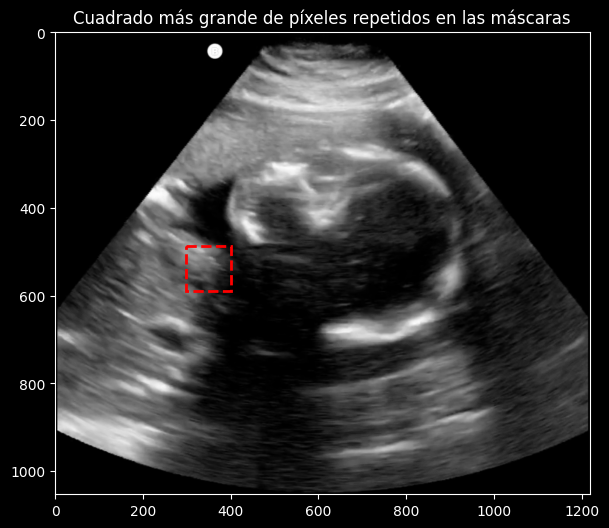

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 1. Definir la máscara común
# Opción estricta: píxeles presentes en todas las máscaras
common_mask = np.all(ob > 0, axis=0)

# Opción con umbral (descomenta la siguiente línea para usarla)
threshold = 0.5 * ob.shape[0]
common_mask = (np.sum(ob > 0, axis=0) >= threshold)

# 2. Función para encontrar el mayor cuadrado de 1's en una matriz binaria
def largest_square_submatrix(binary_matrix):
    rows, cols = binary_matrix.shape
    dp = np.zeros((rows, cols), dtype=int)
    max_size = 0
    max_pos = (0, 0)  # Vértice inferior derecho del cuadrado más grande encontrado
    for i in range(rows):
        for j in range(cols):
            if binary_matrix[i, j]:
                if i == 0 or j == 0:
                    dp[i, j] = 1
                else:
                    dp[i, j] = min(dp[i-1, j], dp[i, j-1], dp[i-1, j-1]) + 1
                if dp[i, j] > max_size:
                    max_size = dp[i, j]
                    max_pos = (i, j)
    return max_size, max_pos

max_size, max_pos = largest_square_submatrix(common_mask)
print("Tamaño del cuadrado más grande:", max_size)
print("Posición (fila, columna) del vértice inferior derecho:", max_pos)

# Calcular la posición del vértice superior izquierdo
top_left = (max_pos[0] - max_size + 1, max_pos[1] - max_size + 1)
print("Posición del vértice superior izquierdo:", top_left)

# 3. Visualización en un frame de ejemplo (por ejemplo, el primer frame del video original)
sample_frame = gt_video[0, :, :]

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(sample_frame, cmap='gray')
# Dibujar el cuadrado encontrado
rect = patches.Rectangle((top_left[1], top_left[0]), max_size, max_size, 
                         edgecolor='red', facecolor='none', linestyle='--', linewidth=2)
ax.add_patch(rect)
ax.set_title('Cuadrado más grande de píxeles repetidos en las máscaras')
plt.show()


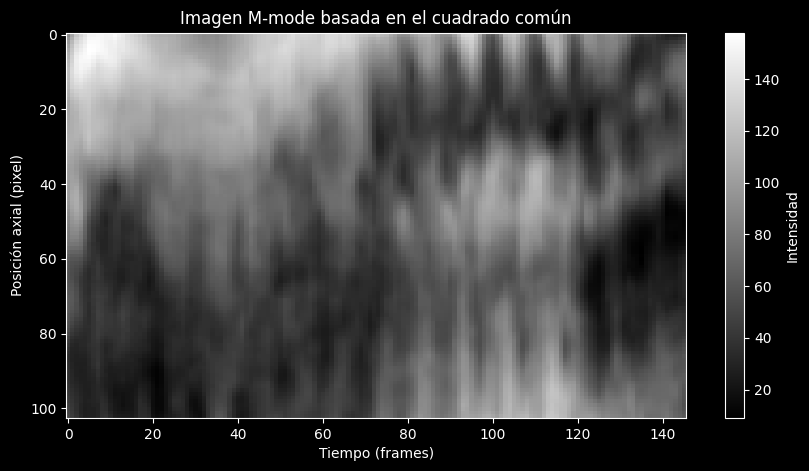

In [35]:
# Extraer la ROI en función del cuadrado común hallado
# Asumimos que:
# - gt_video tiene forma (n_frames, height, width)
# - top_left es una tupla (fila, columna) con la posición del vértice superior izquierdo del cuadrado
# - max_size es el tamaño del cuadrado
roi_video = gt_video[:, top_left[0]:top_left[0] + max_size, top_left[1]:top_left[1] + max_size]

# Generar la imagen M‑mode a partir de la ROI:
# Se promedia a lo largo de las columnas para obtener, en cada frame, un perfil axial.
m_mode_image = np.mean(roi_video, axis=2)  # Resultado con forma (n_frames, max_size)

# Visualizar la imagen M‑mode
plt.figure(figsize=(10, 5))
plt.imshow(m_mode_image.T, aspect='auto', cmap='gray')
plt.title('Imagen M‑mode basada en el cuadrado común')
plt.xlabel('Tiempo (frames)')
plt.ylabel('Posición axial (pixel)')
plt.colorbar(label='Intensidad')
plt.show()


BPM estimados: 143.84


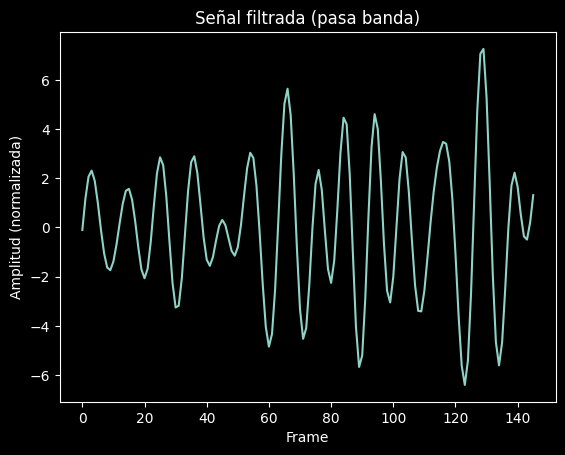

(146, 103)


In [36]:
# Si tienes tu M-mode en la variable m_mode_image:
bpm, freq_dom, signal_filtrada = analizar_m_mode(m_mode_image)
print(f"BPM estimados: {bpm:.2f}")

#Ejemplo de visualización rápida:
plt.figure()
plt.plot(signal_filtrada)
plt.title("Señal filtrada (pasa banda)")
plt.xlabel("Frame")
plt.ylabel("Amplitud (normalizada)")
plt.show()

print(m_mode_image.shape)

In [37]:
import cv2
import imageio
import numpy as np

frames_with_rect = []
for frame in gt_video:
    # Convertir el frame a color si está en escala de grises
    if len(frame.shape) == 2:
        frame_color = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    else:
        frame_color = frame.copy()
    
    # Dibujar el rectángulo sobre el frame.
    # Recuerda: en OpenCV, las coordenadas se expresan como (columna, fila)
    start_point = (top_left[1], top_left[0])
    end_point   = (top_left[1] + max_size, top_left[0] + max_size)
    # Dibujar el rectángulo en color rojo (BGR: (0, 0, 255)) con grosor 2
    cv2.rectangle(frame_color, start_point, end_point, (0, 0, 255), thickness=2)
    
    # Convertir de BGR a RGB para que se muestre correctamente en el GIF
    frame_rgb = cv2.cvtColor(frame_color, cv2.COLOR_BGR2RGB)
    frames_with_rect.append(frame_rgb)

# Crear y guardar el GIF (ajusta el fps según desees)
gif_filename = 'video_with_square.gif'
imageio.mimsave(gif_filename, frames_with_rect, fps=10)
print(f"GIF guardado como {gif_filename}")


GIF guardado como video_with_square.gif


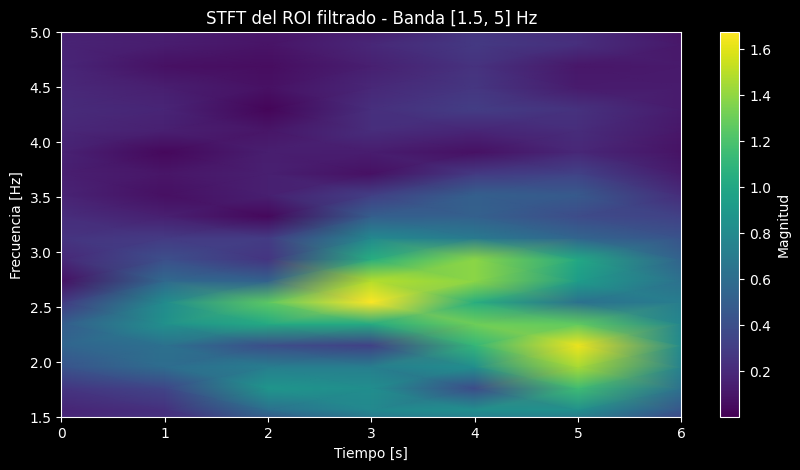

Frecuencia dominante: 2.34 Hz, equivalente a 140.6 BPM


In [38]:
from scipy.signal import butter, filtfilt, stft
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Extraer la ROI definida por el cuadrado común ---
roi_video = gt_video[:, top_left[0]:top_left[0]+max_size, top_left[1]:top_left[1]+max_size]

# --- 2. Extraer la señal promediando la ROI en cada frame ---
signal = np.mean(roi_video, axis=(1,2))
signal = signal - np.mean(signal)  # eliminar componente DC

# --- 3. Aplicar un filtro pasa banda para aislar la banda de interés ---
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

fs = 25  # 25 fps
lowcut = 1.5  # límite inferior en Hz (~90 BPM)
highcut = 5   # límite superior en Hz (~300 BPM)

b, a = butter_bandpass(lowcut, highcut, fs, order=4)
signal_filtered = filtfilt(b, a, signal)

# --- 4. Calcular la STFT sobre la señal filtrada ---
nperseg = 100 if len(signal_filtered) >= 100 else len(signal_filtered)
noverlap = int(nperseg * 0.75)
nfft = 128  # para mejorar la resolución en frecuencia

f, t_stft, Zxx = stft(signal_filtered, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
spectrogram = np.abs(Zxx)

# --- 5. Visualizar el espectrograma en el rango de interés ---
plt.figure(figsize=(10, 5))
plt.pcolormesh(t_stft, f, spectrogram, shading='gouraud', cmap='viridis')
plt.title('STFT del ROI filtrado - Banda [1.5, 5] Hz')
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [Hz]')
plt.colorbar(label='Magnitud')
plt.ylim(1.5, 5)
plt.show()

# --- 6. Encontrar la frecuencia dominante y convertirla a BPM ---
mean_spectrum = np.mean(spectrogram, axis=1)
idx_peak = np.argmax(mean_spectrum)
dominant_freq = f[idx_peak]  # en Hz
bpm = dominant_freq * 60

print(f"Frecuencia dominante: {dominant_freq:.2f} Hz, equivalente a {bpm:.1f} BPM")
